In [33]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from PIL import Image
import time
import os
import copy
import pandas as pd

plt.ion()

In [3]:
df = pd.read_csv('./data/annotations.csv', names=['image', 'xmin', 'ymix', 'xmax', 'ymax', 'class'])
df.head()

,image,xmin,ymix,xmax,ymax,class
0,/home/ujjwal/Desktop/Intel-Hackathon/data/imag...,876,531,919,545,vehicle fallback
1,/home/ujjwal/Desktop/Intel-Hackathon/data/imag...,877,544,924,572,bus
2,/home/ujjwal/Desktop/Intel-Hackathon/data/imag...,850,554,876,561,car
3,/home/ujjwal/Desktop/Intel-Hackathon/data/imag...,883,566,926,582,car
4,/home/ujjwal/Desktop/Intel-Hackathon/data/imag...,859,580,987,697,car


In [7]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

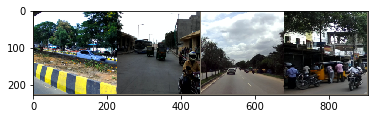

In [9]:
# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out)

In [10]:
labels = {0: 'vehicle fallback',
 1: 'bus',
 2: 'car',
 3: 'truck',
 4: 'motorcycle',
 5: 'autorickshaw',
 6: 'rider',
 7: 'person',
 8: 'traffic light',
 9: 'traffic sign',
 10: 'animal',
 11: 'bicycle',
 12: 'caravan'}

inv_labels = {v: k for k, v in labels.items()}

In [29]:
df['image'] = df['image'].apply(lambda x: x.split('/')[-1])
df['class'] = df['class'].apply(lambda x: inv_labels_labels[x])
df.to_csv('frame.csv', index=None)

In [173]:
class Rectangle(object):
    def __init__(self, xmin, ymin, xmax, ymax):
        if xmin >= xmax or ymin >= ymax:
            self.xmin_ = None
            self.ymin_ = None
            self.xmax_ = None
            self.ymax_ = None
        else:
            self.xmin_ = xmin
            self.ymin_ = ymin
            self.xmax_ = xmax
            self.ymax_ = ymax
        self.coords = (xmin,ymin,xmax,ymax)

    def __eq__(self, other):
        return ((self.xmin_ == other.xmin_) and (self.ymin_ == other.ymin_) and
            (self.xmax_ == other.xmax_) and (self.ymax_ == other.ymax_))

    def __ne__(self, other):
        return not self.__eq__(other)

    def is_empty(self):
        return ((self.xmin_ is None) or (self.ymin_ is None) or
            (self.xmax_ is None) or (self.ymax_ is None) or
            (self.xmin_ >= self.xmax_) or (self.ymin_ >= self.ymax_))

    def width(self):
        return self.xmax_ - self.xmin_ 

    def height(self):
        return self.ymax_ - self.ymin_ 

    def area(self):
        return self.width() * self.height()

    def intersect(self, other):
        xmin = max(self.xmin_, other.xmin_)
        ymin = max(self.ymin_, other.ymin_)
        xmax = min(self.xmax_, other.xmax_)
        ymax = min(self.ymax_, other.ymax_)
        return Rectangle(xmin, ymin, xmax, ymax)

    def intersects(self, other):
        return not (self.is_empty() or other.is_empty() or
                (other.xmax_ <= self.xmin_) or (self.xmax_ <= other.xmin_) or
                (other.ymax_ <= self.ymin_) or (self.ymax_ <= other.ymin_))

    def contains(self, x, y):
        return ((x >= self.xmin_) and (x <= self.xmax_) and
            (y >= self.ymin_) and (y <= self.ymax_))

    def intersect_over_union(self, other):
        if not self.intersects(other):
            return 0.0
        intersect_rect = self.intersect(other)
        if intersect_rect.is_empty():
            return 0.0

        if self.area() == 0 or other.area() == 0:
            return 0.0
        
        return intersect_rect.area() / (self.area() + other.area() - intersect_rect.area())

In [168]:
class IIDDataset(Dataset):
    """IID dataset."""

    def __init__(self, csv_file, root_dir, type_='trainval', transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.frame = pd.read_csv(csv_file)
        self.group = self.frame.groupby('image')
        self.unique_frame = self.frame.image.unique()
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.frame.image.unique())
    
    def transform(self, image, boxes):
        if type_ == 'trainval':
            flip = transforms.RandomHorizontalFlip()
        return image, mask

    def __getitem__(self, index):
        image = Image.open(self.image_paths[index])
        mask = Image.open(self.target_paths[index])
        x, y = self.transform(image, mask)
        return x, y

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir,
                                self.unique_frame[idx])
        image = Image.open(img_name)
        boxes = self.group.get_group(self.unique_frame[idx]).iloc[:,1:-1].values
        labels = self.group.get_group(self.unique_frame[idx]).iloc[:,-1].values
        sample = {'image': image, 'boxes': boxes, 'labels': labels}
        print(boxes)
        print(boxes.shape)
        print(labels.shape)

        if self.transform:
            sample = self.transform(sample)

        return sample

In [169]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor()
    ]),
    'val': transforms.Compose([
        transforms.ToTensor(),
    ]),
}

In [170]:
iid = IIDDataset('frame.csv', 'data/images', data_transforms['train'])

In [171]:
len(iid)

400

In [172]:
inputs, box, label = next(iter(iid))

[[ 876  531  919  545]
 [ 877  544  924  572]
 [ 850  554  876  561]
 [ 883  566  926  582]
 [ 859  580  987  697]
 [ 730  524  830  586]
 [ 789  638  882  771]
 [1077  556 1104  599]
 [1103  556 1145  600]
 [1390  440 1827  742]
 [1274  529 1410  701]
 [1149  529 1253  636]
 [1111  545 1137  553]
 [1113  564 1154  623]
 [1104  565 1148  612]
 [ 669  573  779  658]
 [ 322  582  637  718]
 [   0  610  232  722]
 [   5  680  758 1080]
 [ 577  656  695  803]
 [ 771  604  803  672]
 [ 835  559  875  598]
 [ 842  563  871  602]
 [ 829  569  869  651]
 [ 789  568  869  730]
 [ 763  563  814  662]
 [ 615  561  690  610]
 [ 578  557  613  624]]
(28, 4)
(28,)


TypeError: pic should be PIL Image or ndarray. Got <class 'dict'>